## TESTING TRACERS CODE:

1. Select a halo snapshot.
2. Compute Weigths with : st.weight_triaxial.
3. Compute Stellar properties. For densities purporses we need the masss.
4. Compute the density. Here we use the rho_enclosed function.

## To do:



In [1]:
%pylab inline
#import Stracers as st
import sys
sys.path.append('../MW_anisotropy/code/')
sys.path.append('../MW_anisotropy/code/densities/')
sys.path.append('./Stracers/')
from tracers_dens import *
#import density_tools
import reading_snapshots
from pygadgetreader import *
from smooth import savitzky_golay

from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline

Populating the interactive namespace from numpy and matplotlib


In [2]:
font = {'size':20, 'family':'serif'}
matplotlib.rc('font', **font)

In [3]:
def rho_tracers(r, M, profile, profile_params):
    """
    Density profiles for the
    to-do:

    1. pass as an argument the density function instead of the if statements.
    2. profile paramas as *profile_params
    """
    if profile == 'Plummer':
        rho = dens_plummer(r, M, profile_params[0])
    elif profile == 'Hernquist':
        rho = dens_hernquist(r, M, profile_params[0])
    elif profile == 'NFW':
        rho = dens_NFWnRvir(r, M, profile_params[0], profile_params[1])
    elif profile == 'Einasto':
        rho = dens_Einasto(r, M, profile_params[0], profile_params[1])

    return rho


In [4]:
def rho_enclosed(r_posh, rmin, rmax, nbins, mass):
    r = np.linspace(rmin, rmax, nbins-1)
    rho = np.zeros(nbins-1)

    # Loop over the radial bins.
    for i in range(1, len(r)):
        indexh = np.where((r_posh<r[i]) & (r_posh>r[i-1]))[0]

        rho[i-1] = (3*(np.sum(mass[indexh]))) / (4*np.pi*(r[i]**3-r[i-1]**3))

    return r, rho

In [5]:
def all_host_particles(xyz, vxyz, pids, pot, mass, N_host_particles):
    """
    Function that return the host and the sat particles
    positions and velocities.

    Parameters:
    -----------
    xyz: snapshot coordinates with shape (n,3)
    vxys: snapshot velocities with shape (n,3)
    pids: particles ids
    Nhost_particles: Number of host particles in the snapshot
    Returns:
    --------
    xyz_mw, vxyz_mw, xyzlmc, vxyz_lmc: coordinates and velocities of
    the host and the sat.

    """
    sort_indexes = np.sort(pids)
    N_cut = sort_indexes[N_host_particles]
    host_ids = np.where(pids<N_cut)[0]
    return xyz[host_ids], vxyz[host_ids], pids[host_ids], pot[host_ids], mass[host_ids]

In [655]:
def energies(r_part, Ep, v, m, n_rbins, n_ebins):
    r"""
    
    Parameters:
    -----------
    
    r_part: 'numpy.array`
        Galactocentric distances of the DM particles in [$kpc$].
    pmass: float
        Mass of a DM particle in units of solar masses.
    Ep : 'numpy.array`
        potential energy in units of
    v : 'numpy.array`
        velocities in km/s
    n_rbins : int
        number of bins, this will be used to bin the potential energy.
        
    n_ebins : int
        number of bins, this will be used to bin the energy.
    
    Returns:
    --------
    
    $\Psi$ : $\Psi = -\Phi + \Phi_0$ Relative potential. 
    $\epsilon$ : $\epsilon = -E + \phi_0$ relative total energy.
    
    
    """

    G = 4.30071e-6 # Gadget units
    nbins_coarsed = 20
    E_k = 0.5*v**2 # Kinetic energy / mass.
    Ep = Ep - G*m*len(r)/np.max(r)
    E = E_k + Ep
    shift_energy = 0#-np.min(Ep)
    E += shift_energy
    Ep += shift_energy
    
    epsilon = (-1.0)*E
    

    # Binning the data in logarithmic bins in radius


    rbins = np.logspace(np.min(np.log10(r_part)), np.max(np.log10(r_part)), nbins_coarsed)
    # spaced between rbins
    dr = np.zeros(len(rbins)-1)
    for i in range(len(rbins)-1):
        dr[i] = rbins[i+1] - rbins[i]

    pot = np.zeros(nbins_coarsed-1)

    for i in range(len(rbins)-1):
        index_bins = np.where((r_part<rbins[i+1])
                              & (r_part>=rbins[i]))[0]

        if len(index_bins) == 0:
            pot[i] = 0
            print('Warning : No particles found at r={:0>2f} kpc'.format(rbins[i]))
        else:
            pot[i] = np.mean(Ep[index_bins])

    E-=shift_energy
    epsilon-=shift_energy
    pot-=shift_energy
    
    f_interp_pot = interp1d(rbins[:-1]+dr, pot, kind='cubic')
    r_interp = np.linspace(rbins[0]+dr[0], rbins[-2]+dr[-2], n_rbins)
    pot_interp = f_interp_pot(r_interp)
    psi = (-1.0)*pot_interp



    #Binning Energy for g(E) and f(E) (f(epsilon)) calculations

    
    Histo_E, Edges = np.histogram(E, bins=n_ebins)
    Histo_epsilon, epsedges = np.histogram(epsilon, bins=n_ebins)

    # Are these always positive?
    dE = np.zeros(len(Edges-1))
    for i in range(len(Edges)-1):
        dE = Edges[i+1]-Edges[i]
        
    depsilon = np.zeros(len(epsedges-1))
    for i in range(len(epsedges)-1):
        dE = epsedges[i+1]-epsedges[i]

    Edges = Edges + dE/2.
    epsedges = epsedges + depsilon/2.
    
    


    return r_interp, pot_interp, E, psi, Histo_E, Edges, Histo_epsilon, epsedges

# Distribution function:

In [656]:
def densities_derivatives(rbins, psi_bins, interp_bins=100, profile='Hernquist'):
    """
    Computes the derivatives of 
    
    rbins : number of radial bins.
    
    psi_bins : psi binned.
    
    inter_bins : int
        Values of the interpolated 
    
    
    """
    assert len(rbins)==len(psi_bins), "Length of r and psi are not equal and I can't interpolate "
    
    spl1 = InterpolatedUnivariateSpline(rbins, psi_bins)

    # interpolating in the radial bins.  
    rbins_hr = np.linspace(min(rbins), max(rbins), interp_bins)
    #nu_tracer_hr = spl1(rbins_hr)
    nu_tracer=rho_tracers(rbins_hr, 2.82E10, profile, [3])/2.82E10
    psi_hr = spl1(rbins_hr)

    # First derivative.
    dnu_dpsi = np.gradient(nu_tracer, psi_hr)
    #spl3 = interp1d(rbins, dnu_dpsi, kind='cubic')
    #dnu_dpsi_hr = spl3(rbins_hr)

    # second derivative
    #dnu2_dpsi2 = np.gradient(dnu_dpsi, psi2)
    
    # smoothing first derivative
    #dnu_dpsi_smooth = savitzky_golay(dnu_dpsi, 5, 3)
    dnu2_dpsi2 = np.gradient(dnu_dpsi, psi_hr)
    # smoothing second derivative
    #dnu2_dpsi2_smooth = savitzky_golay(dnu2_dpsi2, 5, 3)

    return rbins_hr, nu_tracer, psi_hr, dnu_dpsi, dnu2_dpsi2

In [657]:
def distribution_function(psi, dnu2_dpsi2, epsilon):
    """
    psi : relative potential
    
    dnu2_dpsi2 : second derivative of the tracers density with respect to
                 the relative potential.
    epsilon : Energy of the particles.
    
    
    return:
    -------
    
    df : numpy.array
        Distribution function.
        
        
    """
    
    assert len(epsilon)<len(psi), 'Hey'
    
    factor = 1/(np.sqrt(8)*np.pi**2)
    dpsi = np.zeros(len(psi))
    for i in range(1,len(dpsi)):
        dpsi[i] = np.abs(psi[i]-psi[i-1]) 
    df = np.zeros(len(epsilon))
    
    for i in range(len(epsilon)):
        index = np.where(psi<epsilon[i])[0] 
        if len(index)==0:
            df[i]=0
        else:
            df[i] = np.sum(dpsi[index]/(np.sqrt(epsilon[i] - psi[index])) * dnu2_dpsi2[index])
            if df[i]<=0:
                print(np.sum(np.sqrt(epsilon[i] - psi[index])))
                print('df with negative values, something is wrong.')
                
    
    return factor*df#, savitzky_golay(factor*df, 9, 6)
    

In [658]:
def df_hernquist(E, a, M,  G=4.30071e-6):
    """
    Computes the analytic DF for a Henrquist halo.
    See equation 4.51 in Binney & Tremaine page 290.
    
    Parameters:
    -----------
    
    Epsilon : numpy.array
        Relative energy in (Km/s)**2, Epsion : - E = \Psi -1/2v^2 
    a : float
       Hernquist scale radius.
    M : Float
        Mass of the halo in Msun.
    
    G : float 
        Gravitational constant i units of Kpc*(Km/s)**2 / Msun
        
        
    
    
    """
    
    eps = E*a/(G*M)
    #print(eps)
    constants = 1/((2*np.pi)**3 * (G*M*a)**(3/2.))
    factor1 = np.sqrt(eps)/(1-eps)**2
    factor2 = (1-2*eps)*(8*eps**2-8*eps-3) + 3*np.arcsin(np.sqrt(eps))/np.sqrt(eps*(1-eps))
    
    return constants*factor1*factor2

In [659]:
def analytic_nu_derivatives(nu, Psi, a, M, G=4.30071e-6):
    """
    Computes de analytic derivatives of a Hernquist number density profile.
    Uses the equations 4.49 and 4.50 in Binney and Tremaine Ed 2.
    
    Parameters:
    nu : numpy.array
        density of the tracers
        
    Psi : numpy.array
        Relative potential of the particles.
    
    """
    Psi_tilde = Psi*a/(G*M)
    factor = 1/(2*np.pi*a**2*G*M)
    dnu_dpsi_a = factor * (Psi_tilde**3 * (4-3*Psi_tilde)) / (1-Psi_tilde)**2
    dnu2_dpsi2_a = factor/(G*M) * (2*Psi_tilde**2)*(6-8*Psi_tilde + 3*Psi_tilde**2)/(1-Psi_tilde)**3
    
    return Psi_tilde, dnu_dpsi_a, dnu2_dpsi2_a
    

In [660]:
snapshot = './halos/LMC1_97K_vir_000'


pp = readsnap(snapshot, 'pos', 'dm')
vv = readsnap(snapshot, 'vel', 'dm')
mass = readsnap(snapshot, 'mass', 'dm')
Epp = readsnap(snapshot, 'pot', 'dm')
ids = readsnap(snapshot, 'pid', 'dm')

print(np.sum(mass))
r = np.sqrt(pp[:,0]**2+pp[:,1]**2+pp[:,2]**2)

# truncating the halo

r_cut = index = np.where((r<300)& (r>0))[0]

pp = pp[r_cut]
r = r[r_cut]
vv = vv[r_cut]
mass = mass[r_cut]
Epp = Epp[r_cut]
ids = ids[r_cut]

v = np.sqrt(vv[:,0]**2 + vv[:,1]**2 + vv[:,2]**2)

m_tr = np.sum(mass)*1E10
print(m_tr)


Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass
Returning DM    Potential
Returning DM    Particle IDs
2.99862
29429402351.4


In [661]:
rbins, pot, E, psi, Histo_E, Edges, Histo_epsilon, eps_edges = energies(r, Epp, v, mass[0]*1E10, 1000, 100)

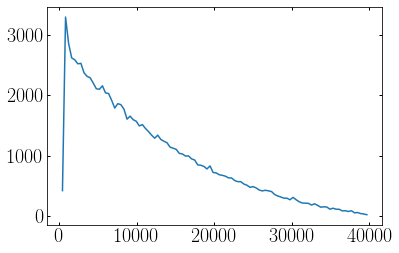

In [662]:
plot(eps_edges[:-1], Histo_epsilon) 


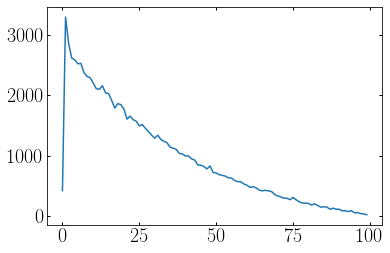

In [663]:
plot(Histo_epsilon)

In [664]:
max(r)

299.97778

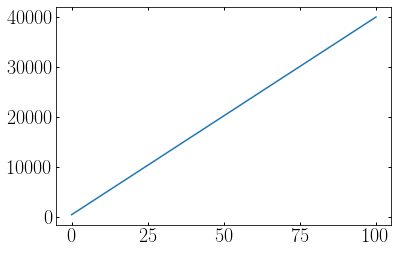

In [665]:
plot(np.linspace(0, 100, 101), eps_edges)

In [666]:
print(len(rbins), len(psi))

1000 1000


/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


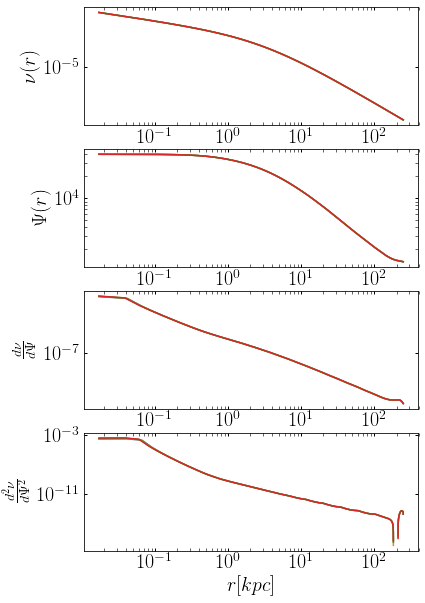

In [667]:
figure(figsize=(6, 10))

for i in range(10000, 12000, 500):
    r_hr,  nu_tracer, psi_hr, dnu_dpsi_smooth, dnu2_dpsi2_smooth = densities_derivatives(rbins, 
                                                                                         psi, 
                                                                                         interp_bins=i,
                                                                                         profile='Hernquist')
    subplot(4, 1, 1)
    loglog(r_hr, nu_tracer)
    ylabel(r'$\nu(r)$')
    
    subplot(4, 1, 2)
    loglog(r_hr, psi_hr)
    ylabel(r'$\Psi(r)$')

    subplot(4, 1, 3)
    loglog(r_hr, dnu_dpsi_smooth)
    ylabel(r'$\frac{d\nu}{d\Psi}$')

    subplot(4, 1, 4)
    loglog(r_hr, dnu2_dpsi2_smooth)
    ylabel(r'$\frac{d^2\nu}{d\Psi^2}$')
    xlabel(r'$r[kpc]$')
    

In [668]:
psi_a, dnu_dpsi_a, dnu2_dpsi2_a = analytic_nu_derivatives(nu_tracer, psi_hr, a=3, M=m_tr)

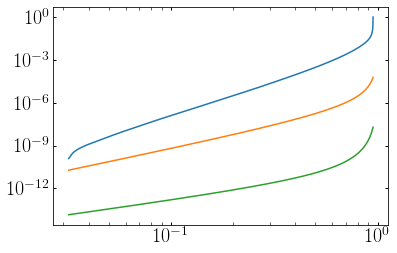

In [669]:
loglog(psi_a, nu_tracer)
loglog(psi_a, dnu_dpsi_a)
loglog(psi_a, dnu2_dpsi2_a)

Text(0,0.5,'$\\nu, d\\nu d\\Psi, d\\nu^2 d \\Psi^2$')

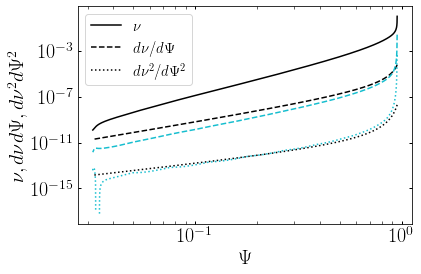

In [670]:

loglog(psi_a, nu_tracer, label=r'$\nu$', ls='-', c='k')
loglog(psi_a, dnu_dpsi_a, label=r'$d\nu/d\Psi$', ls='--', c='k')
loglog(psi_a, dnu2_dpsi2_a, label=r'$d\nu^2/d\Psi^2$', ls=':', c='k')

loglog(psi_a, dnu_dpsi_smooth, c='C9', ls='--')
loglog(psi_a, dnu2_dpsi2_smooth, c='C9', ls=':')

legend(fontsize=15)
xlabel(r'$\Psi$')
ylabel(r'$\nu, d\nu d\Psi, d\nu^2 d \Psi^2$')
#savefig('derivatives_dnu_dpsi.pdf', bbox_inches='tight')



Text(0.5,1,'$M=2.82 \\times 10^{10} M_{\\odot}, \\ a=3 kpc$')

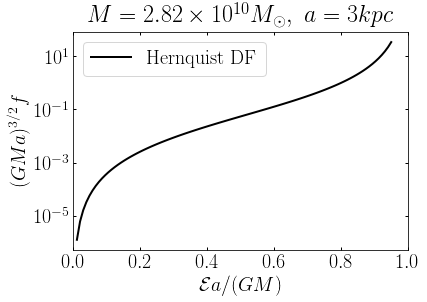

In [671]:

df_h = df_hernquist(eps_edges, 3, m_tr)

semilogy(eps_edges*3/(m_tr*4.30071e-6), df_h*(m_tr*4.30071e-6*3)**(3/2.), c='k', lw=2, label='Hernquist DF')
xlabel(r'$\mathcal{E} a / (GM)$')
ylabel(r'$(GMa)^{3/2} f$')
xlim(0, 1)
legend()
title(r'$M=2.82 \times 10^{10} M_{\odot}, \ a=3 kpc$')

## Consistent with figure 4.2 in Binney and Tramaine.
## Using the energies from the DM particle of the N-body simulation

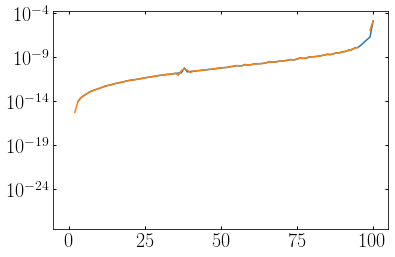

In [672]:
df = distribution_function(psi_hr, dnu2_dpsi2_smooth, eps_edges)
semilogy(df)
semilogy(df_smooth)

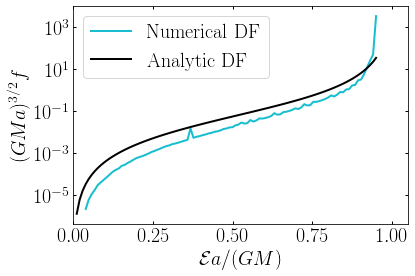

In [673]:
plt.semilogy(eps_edges*3/(m_tr*4.30071e-6), (df*(m_tr*4.30071e-6*3)**(3/2.)), c='C9', lw=2, label='Numerical DF')
plt.semilogy(eps_edges*3/(m_tr*4.30071e-6), df_h*(m_tr*4.30071e-6*3)**(3/2.), c='k', lw=2, label='Analytic DF')

xlabel(r'$\mathcal{E} a / (GM)$')
ylabel(r'$(GMa)^{3/2} f$')
xlim(0, 1.05)
legend()

savefig('DF_Hernquist.pdf', bbox_inches='tight')

## Density of states:

\begin{equation}
g(E) = (4\pi)^2 \int_0^{r_E} r^2 \sqrt{2(E-\Phi(r))} dr
\end{equation}

In [674]:
def density_of_states(rbins, E, pot):
    """
    Compute the density of states.
    
    g(E) = (4\pi)^2 \int_0^{r_E} r^2 \sqrt{2(E-\Phi(r))} dr
    
    Parameters:
    -----------
    rbins : numpy.array
        Array with
    E : numpy.array
        Total Energy.
    pot: numpy.array
        Potential Energy.
    
    Returns:
    --------
    
    g_E : numpy.array
        Density of states.
    
    """
    
    factor = (4*np.pi)**2
    g_E = np.zeros(len(E))
    
    dr = np.zeros(len(rbins))
    for i in range(1,len(dr)):
        dr[i] = rbins[i]-rbins[i-1]
        
    
    for i in range(len(E)):
        index = np.where(pot<=E[i])[0]
        if len(index)==0:
            g_E[i] = 0
            print('g(E)=0')
        else:
            r = rbins[0:max(index)+1]
            # the plus+1 differes with Chervins implemantation.
            g_E[i] = factor*np.sum(r**2 * dr[0:max(index)+1] * np.sqrt(2*(E[i]-pot[0:max(index)+1])))
    return g_E

In [675]:
g_E = density_of_states(rbins, Edges, pot)

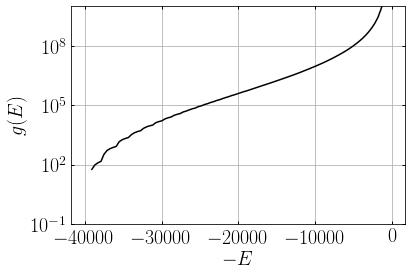

In [676]:
semilogy(Edges, g_E, c='k')
xlabel('$-E$')
ylabel('$g(E)$')
ylim(1E-1, 1E10)
grid()
plt.savefig('gE.pdf', bbox_inches='tight')

In [677]:
def differential_energy_distribution(hist_E, E_bins, m_part):
    """
    Differential Energy distribution.
    
    N(E) = n / dE
    
    n : number of particles with energy [E, E+dE].
    dE : Energy interval.
    
    Parameters:
    -----------
    hist_E : 
    
    """
    N_E = np.zeros(len(hist_E))
    for i in range(len(hist_E)):
        dE = np.abs(E_bins[i+1]-E_bins[i])
        N_E[i] = hist_E[i]*m_part / dE
    
    return N_E, savitzky_golay(N_E, 13, 3) # smoothing the curve

In [678]:
Histo_E, smooth_Histo_E = differential_energy_distribution(Histo_E, Edges, mass[0]*1E10)

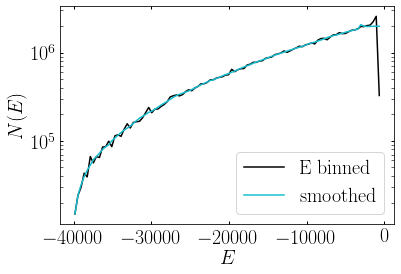

In [679]:
semilogy(Edges[:-1], Histo_E, c='k', label='E binned')
semilogy(Edges[:-1], smooth_Histo_E, c='C9', label='smoothed')
xlabel('$E$')
ylabel('$N(E)$')
legend()
plt.savefig('N_E.pdf', bbox_inches='tight')



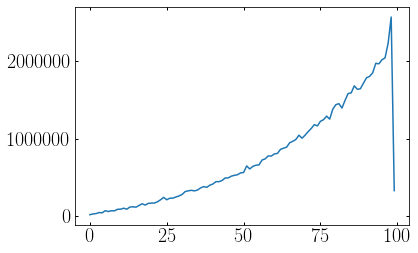

In [680]:
plot(Histo_E)

In [681]:
print(len(smooth_Histo_E), len(g_E))

100 101


In [682]:
def cast_weights(w, E_part, E_bins):
    """
    Assigns weights to each DM particle.
    For each energy bin it finds all the particles that
    have that energy and give the weight corresponding to that
    energy bin.
    
       
    """
    part_weights = np.zeros(len(E_part))
    for i in range(1,len(E_bins)):
        index_part_E = np.where((E_part<E_bins[i]) & (E_part>=E_bins[i-1]))
        part_weights[index_part_E] = w[i]
    
        
    return part_weights

In [683]:
def weights(r, Epp, v, mp):
    """
    Computes weights
    
    
    """
    
    print('Number of particles : ', len(r))
    # Computes energies!
    rbins, pot, E, psi, Histo_E, Edges, Histo_epsilon, eps_edges = energies(r, Epp, v, mp, 1000, 100)
    
    # Computes N_E
    N_E, N_E_smooth = differential_energy_distribution(Histo_E, Edges, mp)
    
    
    # Density of states. size = len(Edges)
    g_E = density_of_states(rbins, Edges, pot)
    
    #  Tracers densities derivatives.
    r_hr,  nu_tracer, psi_hr, dnu_dpsi_smooth, dnu2_dpsi2_smooth = densities_derivatives(rbins, 
                                                                                         psi, 
                                                                                         interp_bins=10000,
                                                                                         profile='Hernquist')
    
    # Distribution function (f size = interp_bins)
    
    f = distribution_function(psi_hr, dnu2_dpsi2_smooth, eps_edges)
    #f = df_hernquist(eps_edges, 3, 2.82E10)

    # Interpolating g(E) and N(E)
    n_interp = 10000
    E_edges_inter = np.linspace(min(Edges), max(Edges[:-1]), n_interp)
    
    g_E_interp = interp1d(Edges, g_E)
    g_E_I = g_E_interp(E_edges_inter)
    
    N_E_interp = interp1d(Edges[:-1], N_E_smooth)
    N_E_I = N_E_interp(E_edges_inter)
    
    f_E_interp = interp1d(-Edges, f)
    f_E_I = f_E_interp(-E_edges_inter)
    
    #print(len(g_E_I), len(N_E_I), len(f_E_I))
    
    
    # Weights
    # reverse f(eps) because Eps = -E
    w = f_E_I[::-1]*g_E_I / N_E_I
    
    w_p = cast_weights(w, E, E_edges_inter)
    print('sum of weights * m_p = ', sum(w_p)*mp, 'Number of weights: ', len(w_p))
    return w_p
    

In [684]:
ww = weights(r, Epp, v, mass[0]*1E10)

Number of particles :  95199
sum of weights * m_p =  0.85824220933 Number of weights:  95199


(array([  8.55200000e+03,   5.55300000e+04,   2.90230000e+04,
          1.74100000e+03,   2.10000000e+02,   5.20000000e+01,
          1.90000000e+01,   2.00000000e+01,   3.60000000e+01,
          1.60000000e+01]),
 array([  0.00000000e+00,   1.66635489e-11,   3.33270977e-11,
          4.99906466e-11,   6.66541954e-11,   8.33177443e-11,
          9.99812931e-11,   1.16644842e-10,   1.33308391e-10,
          1.49971940e-10,   1.66635489e-10]),
 <a list of 10 Patch objects>)

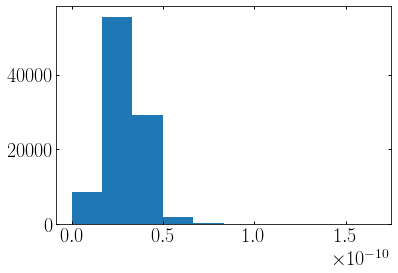

In [685]:
hist(ww)

## Testing weights

In [686]:

def stellar_quantity_test(weights, pq):
    """
    Assign the stellar particle weights to a given physical
    quantity (pq).

    Parameters:
    ----------

    Returns:
    --------


    """

    assert len(weights)==len(pq) , 'Length of weights different to those of the physical quantity'


    phys_quantitiy_w = pq * weights

    return phys_quantitiy_w

In [687]:
def radial_dens(r, m, rbins):
    r_bins = np.linspace(0, 100, rbins)
    rho_bins = np.zeros(rbins-1)
    for i in range(1, len(r_bins)):
        index = np.where((r<r_bins[i]) & (r>=r_bins[i-1]))[0]
        V = 4/3. * np.pi * (r_bins[i]**3-r_bins[i-1]**3)
        rho_bins[i-1] = np.sum(m[index]) / V
    return rho_bins

In [688]:
m_tracers = stellar_quantity_test(ww, mass*m_tr)

In [689]:
rho_st_profile = radial_dens(r, m_tracers, 100)
rho_dm_profile = radial_dens(r, mass, 100)

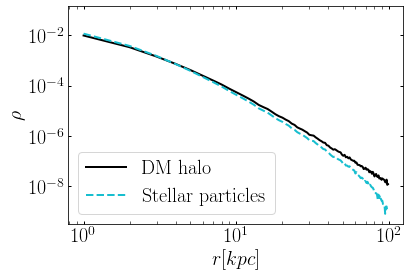

In [690]:
loglog(rho_dm_profile, c='k', label='DM halo', lw=2)
loglog(rho_st_profile, c='C9', ls='--', label='Stellar particles', lw=2)
xlabel('$r[kpc]$')
ylabel(r'$\rho$')
legend()
savefig('stellar_dm_halo_density_profile.pdf', bbox_inches='tight')


In [361]:
from density_tools import density_nn, density_peaks

In [613]:
rho_st_halo = density_nn(pp, 100, 100, 0, 1000, mass=m_tracers)

0

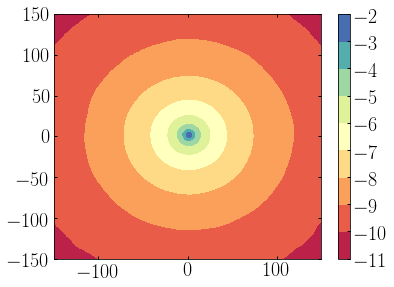

In [614]:
density_peaks(np.log10(rho_st_halo), xmin=-150, xmax=150, ymin=-150, ymax=150, fsize=(6, 4.5))


In [615]:
rho_dm_halo = density_nn(pp, 100, 100, 0, 1000, mass=mass)

0

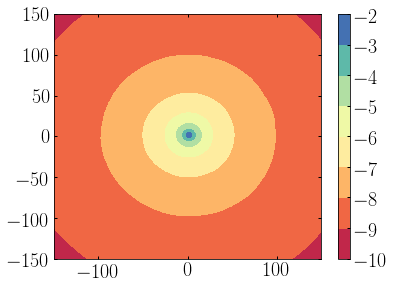

In [616]:
density_peaks(np.log10(rho_dm_halo), xmin=-150, xmax=150, ymin=-150, ymax=150, fsize=(6, 4.5))


0

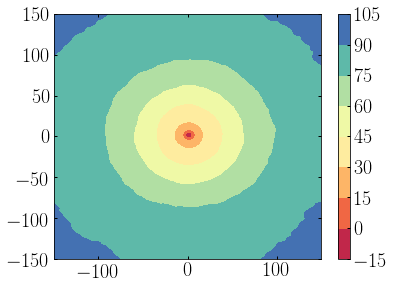

In [617]:
density_peaks(((rho_dm_halo-rho_st_halo)/(rho_dm_halo))*100, xmin=-150, xmax=150, ymin=-150, ymax=150, fsize=(6, 4.5))
